In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
import numpy as np
import pandas as pd
import h5py
from tqdm import tqdm
import scipy.io as sio
from scipy import stats
from importlib import reload
from matplotlib import pyplot as plt
import sys
sys.path.append('/home/jma819/post_cmfe_analysis')
import python_utils_jjm as utils_jjm
import dlc_utils
import caiman
import statsmodels.formula.api as smf
import scipy.spatial.distance as dist
import itertools

/home/jma819/.conda/envs/caiman/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.decomposition.incremental_pca module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.decomposition. Anything that cannot be imported from sklearn.decomposition is now part of the private API.
  warnings.warn(message, FutureWarning)


In [42]:
reload(dlc_utils)
reload(utils_jjm)

<module 'python_utils_jjm' from '/home/jma819/post_cmfe_analysis/python_utils_jjm.py'>

In [3]:
#load and prep data
dir_path_cnmfe = '/projects/p30771/MATLAB/CNMF_E_jjm/quest_MATLAB_cnmfe/batch_output_files/27-Mar_00_48_46_out.mat'
dir_path_tracking = '/projects/p30771/dlc_analysis/openfield_dlc_output/GRIN035_H14_M40_S34/GRIN035_H14_M40_S34_dlc_tracking_foranalysis_04142020.csv'

In [22]:
C_z_scored, interpolated = utils_jjm.prepare_timedelta_dfs(dir_path_cnmfe, dir_path_tracking)

In [5]:
#spatial components
com_df, spatial_components = utils_jjm.return_spatial_info(dir_path_cnmfe, 0.6)

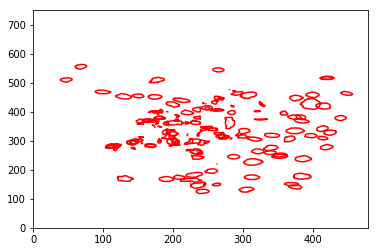

In [6]:
#spatial contours
cell_contours, x, y, cell_dims = utils_jjm.create_contour_layouts(spatial_components)
##if plotting
to_plot = np.array(list(cell_contours.values()))
for i in range(len(to_plot)):
    plt.contour(y, x, to_plot[i], [0.6], colors='r')

In [7]:
C_z_scored = utils_jjm.filter_out_by_size(C_z_scored, cell_contours, cell_dims, 0.6, 100)

In [8]:
to_filter_out = np.array([cell for cell in range(1, len(cell_contours)+1) if len(np.array(np.where(cell_dims[cell]>0.6)[0]))<100])

In [14]:
to_filter_out

array([ 10,  12,  18,  36,  38,  39,  40,  41,  43,  62,  63,  65,  72,
        73,  76,  83,  86,  87,  88,  93,  97, 100, 104, 107, 108, 111,
       112, 113, 114, 115, 117, 118, 119, 120, 122, 124, 125, 127, 128,
       129, 130, 131, 132, 133, 135])

In [20]:
#C_z_scored

In [24]:
#C_z_scored.drop(list(to_filter_out), axis=1, inplace=True)

In [31]:
#com_df.drop(list(to_filter_out), axis=0, inplace=True)

In [34]:
#list(com_df.index)

In [ ]:
# plotting individual cell fluorescence 
plt.plot(C_z_scored[10][0:4000])
plt.show()

## individual cell regression

In [ ]:
if len(C_z_scored) > len(interpolated):
    C_z_scored = C_z_scored.iloc[0:len(interpolated)]

In [ ]:
## inputs are downsampling interval, number of bins, body part to use for velocity correlation, velocity dataframe, fluorescence dataframe 
cells_C_binned_by_V, cells_mean_C_binned_by_V = dlc_utils.downsample_session_and_bin_C_by_V(1, 50, 'centroid', interpolated, C_z_scored)

In [ ]:
regression_results = dlc_utils.create_regression_models_per_cell(cells_mean_C_binned_by_V, 2)

In [ ]:
regression_results[2]['statsmodel_results'].summary()

In [ ]:
print(regression_results[cell]['statsmodel_results'].summary().tables[0][0][3].data)

In [ ]:
cell=4
#label
print(regression_results[cell]['statsmodel_results'].summary().tables[0][3][2].data)
#F-stat
print(regression_results[cell]['statsmodel_results'].summary().tables[0][3][3].data)
xp, p1d = dlc_utils.plot_cell_regression(regression_results, cell, cells_mean_C_binned_by_V)
fig = plt.plot(regression_results[cell]['fit_df']['x'].values, regression_results[cell]['fit_df']['y'].values, '.',
              xp, p1d(xp), '--')


In [ ]:
F_stats = np.array([float(regression_results[cell]['statsmodel_results'].summary().tables[0][3][3].data) for cell in range(1, len(regression_results)+1)])

In [ ]:
# to determine cells with significant quadratic regressions
len(np.argwhere(F_stats<0.05))

## plotting event averages

In [ ]:
# downsample velocity and pick maximum values within 200msec 
new_sampling_interval = 2
interpolated = interpolated.set_index(pd.to_timedelta(np.linspace(0, len(interpolated)*(1/20), len(interpolated)), unit='s'), drop=True)
interpolated_downsampled = interpolated.resample(str(new_sampling_interval)+'S').max()
# bin by activity threshold (body_part, resting_time_threshold, active_time_threshold, resting_threshold, activity_threshold)
binned_velocity = dlc_utils.bin_by_activity_threshold(interpolated['tail_base'], 40, 20, 0.5, 0.5)

In [ ]:
#plt.plot(binned_velocity[0:4000])
transition_indicies = utils_jjm.select_trigger_regions(binned_velocity, 0.5, 0.5, 40)

In [ ]:
threshold_regions_df = utils_jjm.average_triggered_regions(C_z_scored, transition_indicies, 40)

In [ ]:
relative_triggered_df = utils_jjm.adjust_triggered_average_plots(binned_velocity, C_z_scored, threshold_regions_df)

In [ ]:
plt.plot(relative_triggered_df.mean(axis=1))
plt.show()

## spatial clustering 

In [43]:
# get euclidean distances between cells
pairwise_distance = utils_jjm.get_pairwise_distance_by_session(com_df)

In [ ]:
pairwise_distance

In [ ]:
## bin fluorescence data (inputs = [bin_width_samples, z_score_threshold)
C_z_scored_binned = C_z_scored.apply(utils_jjm.binning_function_uncrop, args=[20, 3])
C_z_scored_binned.drop(['msCamFrame'], axis=1, inplace=True)

In [ ]:
# get linear pairwise correlation coefficients from binned fluoresence data
pairwise_pearson = utils_jjm.get_linear_pairwise_correlation_coefficients(C_z_scored_binned, com_df)


In [ ]:
pairwise_pearson

In [ ]:
plt.scatter(pairwise_distance.values[0], pairwise_pearson.values[0])
plt.show()

In [ ]:
## fit regression
deg = 2
fit_data = pd.DataFrame(columns=['y', 'x'])
fit_data['y'] = pairwise_pearson.values[0]
fit_data['x'] = pairwise_distance.values[0]

p1d = np.poly1d(np.polyfit(fit_data['x'].values, fit_data['y'].values, deg))
model = np.poly1d(np.polyfit(fit_data['x'].values, fit_data['y'].values, deg))
results = smf.ols(formula='y ~ model(x)', data=fit_data).fit()

xp = np.linspace(0, 400, 400)
fig = plt.plot(fit_data['x'].values, fit_data['y'].values, '.',
              xp, p1d(xp), '--')

In [ ]:
results.summary()

In [ ]:
# get indicies of interpolated dataframe where mouse is moving 
indicies_to_match = interpolated.iloc[0:len(C_z_scored_binned)][interpolated.iloc[0:len(C_z_scored_binned)]['centroid']>2].index

In [ ]:
C_z_scored_moving = C_z_scored_binned.iloc[[interpolated.index.get_loc(value) for value in indicies_to_match]]

In [ ]:
#C_z_scored_moving

In [ ]:
#plt.plot(interpolated['centroid'].values[0:200])
#plt.show()

In [ ]:
#interpolated.loc['00:00:03.550000']

In [ ]:
# get linear pairwise correlation coefficients
pairwise_r_correlation_unbinned_moving = {}
for pair in itertools.combinations(range(1, len(com_df)+1),2):
    pairwise_r_correlation_unbinned_moving[pair] = stats.pearsonr(C_z_scored_moving[pair[0]], C_z_scored_moving[pair[1]])[0]

pairwise_pearson_moving = pd.DataFrame(pairwise_r_correlation_unbinned_moving, index=['pairwise_pearson_r'])


In [ ]:
plt.scatter(pairwise_distance.values[0], pairwise_pearson_moving.values[0])
plt.show()

In [ ]:
## fit regression
deg = 2
fit_data = pd.DataFrame(columns=['y', 'x'])
fit_data['y'] = pairwise_pearson_moving.values[0]
fit_data['x'] = pairwise_distance.values[0]

p1d = np.poly1d(np.polyfit(fit_data['x'].values, fit_data['y'].values, deg))
model = np.poly1d(np.polyfit(fit_data['x'].values, fit_data['y'].values, deg))
results = smf.ols(formula='y ~ model(x)', data=fit_data).fit()

xp = np.linspace(0, 400, 400)
fig = plt.plot(fit_data['x'].values, fit_data['y'].values, '.',
              xp, p1d(xp), '--')

In [ ]:
results.summary()